In [1]:
# %load /Users/facai/Study/book_notes/preconfig.py
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import SVG

逻辑回归在scikit-learn中的实现简介
==============================

分析用的代码版本信息：

```bash
~/W/g/scikit-learn ❯❯❯ git log -n 1
commit d161bfaa1a42da75f4940464f7f1c524ef53484f
Author: John B Nelson <jnelso11@gmu.edu>
Date:   Thu May 26 18:36:37 2016 -0400

    Add missing double quote (#6831)
```

### 0. 总纲

下面是sklearn中逻辑回归的构成情况:

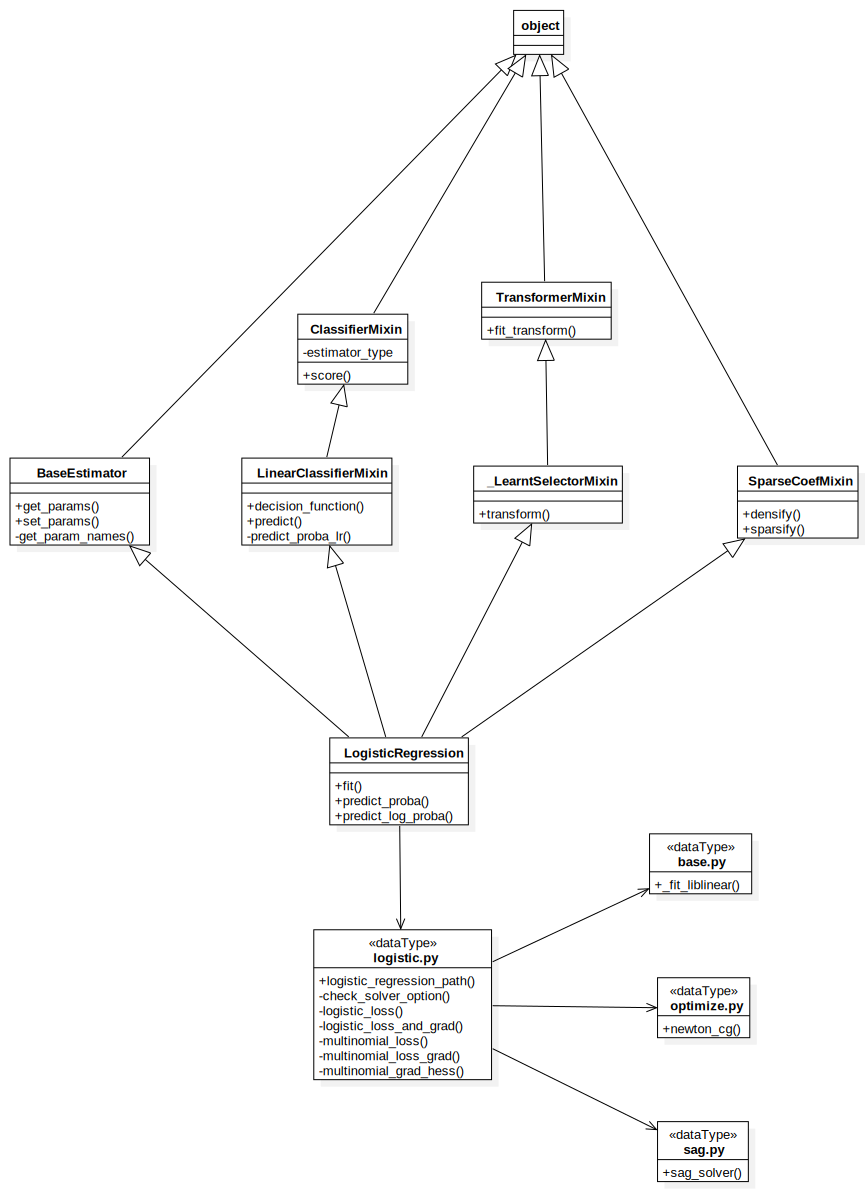

In [2]:
SVG("./res/sklearn_lr.svg")

如[逻辑回归在spark中的实现简介](./spark_ml_lr.ipynb)中分析一样，主要把精力定位到算法代码上，即寻优算子和损失函数。

### 1. 寻优算子

sklearn支持liblinear, sag, lbfgs和newton-cg四种寻优算子，其中lbfgs属于scipy包，liblinear属于LibLinear库，剩下两种由sklearn自己实现。代码很好定位，逻辑也很明了，不多说：

```python
 704         if solver == 'lbfgs':
 705             try:
 706                 w0, loss, info = optimize.fmin_l_bfgs_b(
 707                     func, w0, fprime=None,
 708                     args=(X, target, 1. / C, sample_weight),
 709                     iprint=(verbose > 0) - 1, pgtol=tol, maxiter=max_iter)
 710             except TypeError:
 711                 # old scipy doesn't have maxiter
 712                 w0, loss, info = optimize.fmin_l_bfgs_b(
 713                     func, w0, fprime=None,
 714                     args=(X, target, 1. / C, sample_weight),
 715                     iprint=(verbose > 0) - 1, pgtol=tol)
 716             if info["warnflag"] == 1 and verbose > 0:
 717                 warnings.warn("lbfgs failed to converge. Increase the number "
 718                               "of iterations.")
 719             try:
 720                 n_iter_i = info['nit'] - 1
 721             except:
 722                 n_iter_i = info['funcalls'] - 1
 723         elif solver == 'newton-cg':
 724             args = (X, target, 1. / C, sample_weight)
 725             w0, n_iter_i = newton_cg(hess, func, grad, w0, args=args,
 726                                      maxiter=max_iter, tol=tol)
 727         elif solver == 'liblinear':
 728             coef_, intercept_, n_iter_i, = _fit_liblinear(
 729                 X, target, C, fit_intercept, intercept_scaling, None,
 730                 penalty, dual, verbose, max_iter, tol, random_state,
 731                 sample_weight=sample_weight)
 732             if fit_intercept:
 733                 w0 = np.concatenate([coef_.ravel(), intercept_])
 734             else:
 735                 w0 = coef_.ravel()
 736
 737         elif solver == 'sag':
 738             if multi_class == 'multinomial':
 739                 target = target.astype(np.float64)
 740                 loss = 'multinomial'
 741             else:
 742                 loss = 'log'
 743
 744             w0, n_iter_i, warm_start_sag = sag_solver(
 745                 X, target, sample_weight, loss, 1. / C, max_iter, tol,
 746                 verbose, random_state, False, max_squared_sum, warm_start_sag)
```

### 2. 损失函数

#### 2.1 二分类

二分类的损失函数和导数由`_logistic_loss_and_grad`实现，运算逻辑和[逻辑回归算法简介和Python实现](./demo.ipynb)是相同的，不多说。

#### 2.2 多分类

sklearn的多分类支持ovr (one vs rest，一对多)和multinominal两种方式。


##### 2.2.0 ovr
默认是ovr，它会对毎个标签训练一个二分类的分类器，即总共$K$个。训练代码在

```python
1230         fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
1231                                backend=backend)(
1232             path_func(X, y, pos_class=class_, Cs=[self.C],
1233                       fit_intercept=self.fit_intercept, tol=self.tol,
1234                       verbose=self.verbose, solver=self.solver, copy=False,
1235                       multi_class=self.multi_class, max_iter=self.max_iter,
1236                       class_weight=self.class_weight, check_input=False,
1237                       random_state=self.random_state, coef=warm_start_coef_,
1238                       max_squared_sum=max_squared_sum,
1239                       sample_weight=sample_weight)
1240             for (class_, warm_start_coef_) in zip(classes_, warm_start_coef))
```

注意，1240L的`for class_ in classes`配合1232L的`pos_class=class`，就是逐个取标签来训练的逻辑。

##### 2.2.1 multinominal

前面讲到ovr会遍历标签，逐个训练。为了兼容这段逻辑，真正的二分类问题需要做变化：

```python
1201         if len(self.classes_) == 2:
1202             n_classes = 1
1203             classes_ = classes_[1:]
```

同样地，multinominal需要一次对全部标签做处理，也需要做变化：

```python
1217         # Hack so that we iterate only once for the multinomial case.
1218         if self.multi_class == 'multinomial':
1219             classes_ = [None]
1220             warm_start_coef = [warm_start_coef]
```

好，接下来，我们看multinoinal的损失函数和导数计算代码，它是`_multinomial_loss_grad`这个函数。